# Working with the ECCC GeoAPI

Environment and Climate Change Canada (ECCC) hosts a data server compatible with the [GeoAPI](https://www.geoapi.org/) standard. This notebook shows how to send requests for data to the server and display the results.

## Climate stations

The server holds different [*collections*](https://api.weather.gc.ca/collections?f=html), and requests are made to a particular collection. Here we'll start with the `climate-station` collection, which holds metadata about available stations, but no actual meteorological data. Useful [queryables fields](https://api.weather.gc.ca/collections/climate-stations/queryables) in this collection include `DLY_FIRST_DATE` and `DLY_LAST_DATE`, `ENG_PROV_NAME`, `LATITUDE`, `LONGITUDE` and `ELEVATION` and `STATION_NAME`, among many others. 

### Creating a request to the server for data

Let's start by showing a map of all available stations locations in New-Brunswick. To do so, we first need to compose a URL request. The request includes the address of the server, the collection, then a query to filter results.

In [1]:
import geopandas as gpd
from urlpath import URL

# Compose the request
host = URL("https://api.weather.gc.ca/")
climate_stations = host / "collections" / "climate-stations" / "items"
url = climate_stations.with_query({"ENG_PROV_NAME": "NOVA-SCOTIA"})
print(url)

# Send the request to the server
resp = url.get()
resp

https://api.weather.gc.ca//collections/climate-stations/items?ENG_PROV_NAME=NOVA-SCOTIA


<Response [200]>

The response from the server is a `Response` class instance. What we're interested in is the content of this response, which in this case is a geoJSON file. 

In [2]:
resp.content[:100]

b'{"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {"STN_ID": 6390, "STATI'

We'll open the geoJSON using geopandas. We have a few options to do this: 
- Load the response' content using `json.load`, then create GeoDataFrame using the `from_features` class method;
- Save the response content to a file on disk, then open using `geopandas.read_file`;
- Save the response in an in-memory file using `StringIO`;
- Call `geopandas.read_file(url)` to let geopandas handle the data download.

Here we'll use the last option, as it's the simplest. Note that the first method ignores the feature `id`, which seems to create problems with visualization with folium below.

In [3]:
# The first approach would look like this:
# import json
# stations = gpd.GeoDataFrame.from_features(json.loads(resp.content))

stations = gpd.read_file(str(url))
stations.head()

,id,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,FRE_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,...,HLY_FIRST_DATE,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA,geometry
0,8203165,6390,LOWER MEAGHERS GRANT,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,445500000,-631400000,AST,...,None,None,1967-07-01T00:00:00,1993-06-30T00:00:00,1967-01-01T00:00:00,1993-12-01T00:00:00,Y,N,N,POINT (-63.23333 44.91667)
1,8203396,6398,MALAGASH POINT,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,454700000,-631700000,AST,...,None,None,1989-07-01T00:00:00,2000-04-30T00:00:00,1989-01-01T00:00:00,2000-04-01T00:00:00,Y,N,N,POINT (-63.28333 45.78333)
2,8203400,6399,MALAY FALLS,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,445900000,-622900000,AST,...,1999-01-19T15:00:00,2000-08-31T23:00:00,1950-02-01T00:00:00,2000-08-31T00:00:00,1950-01-01T00:00:00,2000-08-01T00:00:00,Y,N,N,POINT (-62.48333 44.98333)
3,8203422,6400,MARGAREE FORKS,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,462200000,-610500000,AST,...,None,None,1960-10-01T00:00:00,1975-11-30T00:00:00,1960-01-01T00:00:00,1975-12-01T00:00:00,Y,N,N,POINT (-61.08333 46.36667)
4,8203423,6401,MARGAREE FORKS,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,462000000,-610600000,AST,...,None,None,1976-05-01T00:00:00,2004-03-31T00:00:00,1976-01-01T00:00:00,2004-03-01T00:00:00,Y,N,N,POINT (-61.10000 46.33333)


### Filter stations

Now let's say we want to filter the stations that were in operations for at least 50 years. What we'll do is create a new column `n_days` and filter on it. 

In [4]:
import pandas as pd

# Create a datetime.Timedelta object from the subtraction of two dates.
delta = pd.to_datetime(stations["DLY_LAST_DATE"]) - pd.to_datetime(stations["DLY_FIRST_DATE"])

# Get the number of days in the time delta
stations["n_days"] = delta.apply(lambda x: x.days)

# Compute condition 
over_50 = stations["n_days"] > 50 * 365.25

# Index the data frame using the condition
select = stations[over_50]
select.head()

,id,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,FRE_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,...,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA,geometry,n_days
2,8203400,6399,MALAY FALLS,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,445900000,-622900000,AST,...,2000-08-31T23:00:00,1950-02-01T00:00:00,2000-08-31T00:00:00,1950-01-01T00:00:00,2000-08-01T00:00:00,Y,N,N,POINT (-62.48333 44.98333),18474
13,8200100,6289,ANNAPOLIS ROYAL,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,444500000,-653100000,AST,...,None,1914-04-01T00:00:00,2007-06-04T00:00:00,1914-01-01T00:00:00,2006-02-01T00:00:00,Y,N,N,POINT (-65.51667 44.75000),34032
22,8201410,6336,DEMING,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,451259007,-611040090,AST,...,None,1956-10-01T00:00:00,2011-12-31T00:00:00,1956-01-01T00:00:00,2006-02-01T00:00:00,Y,Y,N,POINT (-61.17780 45.21639),20179
26,8202000,6354,GREENWOOD A,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,445900000,-645500000,AST,...,2022-11-20T12:30:02,1942-11-01T00:00:00,2022-11-19T00:00:00,1942-01-01T00:00:00,2017-12-01T00:00:00,Y,Y,Y,POINT (-64.91667 44.98333),29238
30,8205698,6485,SYDNEY,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,460900000,-601200000,AST,...,None,1870-01-01T00:00:00,1941-03-31T00:00:00,1870-01-01T00:00:00,1941-12-01T00:00:00,Y,N,N,POINT (-60.20000 46.15000),26021


### Map the data

We can then simply map the locations of station with at least 50 years of data using the `explore` method. This will display an interactive base map and overlay the station locations, where on a station marker will display this station's information. 

On top of this map, we'll add controls to draw a rectangle. To use the drawing tool, click on the square on the left hand side menu, and the click and drag to draw a rectangle over the area of interest. Once that's done, click on the Export button on the right of the map. This will download a file called `data.geojson` 

In [5]:
from folium.plugins import Draw

# Add control to draw a rectangle, and an export button.
draw_control = Draw(draw_options={
            "polyline": False,
            "poly": False,
            "circle": False,
            "polygon": False,
            "marker": False,
            "circlemarker": False,
            "rectangle": True,
        }, export=True)

m = stations.explore("n_days")
draw_control.add_to(m)
m

### Filter stations using bounding box

Next, we'll use the bounding box drawn on the map to select a subset of stations. We first open the `data.geojson` file downloaded to disk, create a shapely object and use it filter stations.

In [6]:
# Adjust directory if running this locally. 
# rect = gpd.read_file("~/Downloads/data.geojson")

# Here we're using an existing file so the notebook runs without user interaction.
rect = gpd.read_file("./data.geojson")

# Filter stations DataFrame using bbox
inbox = select.within(rect.loc[0].geometry)

print("Number of stations within subregion: ", sum(inbox))
sub_select = select[inbox]
sub_select.head()

Number of stations within subregion:  9


,id,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,FRE_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,...,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA,geometry,n_days
22,8201410,6336,DEMING,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,451259007,-611040090,AST,...,None,1956-10-01T00:00:00,2011-12-31T00:00:00,1956-01-01T00:00:00,2006-02-01T00:00:00,Y,Y,N,POINT (-61.17780 45.21639),20179
30,8205698,6485,SYDNEY,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,460900000,-601200000,AST,...,None,1870-01-01T00:00:00,1941-03-31T00:00:00,1870-01-01T00:00:00,1941-12-01T00:00:00,Y,N,N,POINT (-60.20000 46.15000),26021
34,8206300,6506,WHITEHEAD,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,451300000,-611100000,AST,...,None,1883-12-01T00:00:00,1960-06-30T00:00:00,1883-01-01T00:00:00,1960-12-01T00:00:00,Y,N,N,POINT (-61.18333 45.21667),27970
124,8201000,6329,COLLEGEVILLE,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,452900000,-620100000,AST,...,None,1916-06-01T00:00:00,2016-09-30T00:00:00,1916-01-01T00:00:00,2006-02-01T00:00:00,Y,Y,N,POINT (-62.01667 45.48333),36646
149,8205600,6481,STILLWATER,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,451100000,-620000000,AST,...,None,1915-12-01T00:00:00,1979-10-31T00:00:00,1915-01-01T00:00:00,1979-12-01T00:00:00,Y,N,N,POINT (-62.00000 45.18333),23345


### Request meteorological data

Now we'll make a request for actual meteorological data from the stations filtered above. For this, we'll use the 
Daily Climate Observations collection (`climate-daily`). Here, we're picking just one station but we could easily loop on each station. 

In [7]:
coll = host / "collections" / "climate-daily" / "items"
station_id = sub_select.iloc[0].CLIMATE_IDENTIFIER

# Restricting the number of entries returned to keep things fast.
url = str(coll.with_query({"CLIMATE_IDENTIFIER": station_id, "limit": 365}))
print("Request: ", url)
data = gpd.read_file(url)
data.head()

Request:  https://api.weather.gc.ca//collections/climate-daily/items?CLIMATE_IDENTIFIER=8201410&limit=365


,id,STATION_NAME,CLIMATE_IDENTIFIER,ID,LOCAL_DATE,PROVINCE_CODE,LOCAL_YEAR,LOCAL_MONTH,LOCAL_DAY,MEAN_TEMPERATURE,...,SPEED_MAX_GUST_FLAG,COOLING_DEGREE_DAYS,COOLING_DEGREE_DAYS_FLAG,HEATING_DEGREE_DAYS,HEATING_DEGREE_DAYS_FLAG,MIN_REL_HUMIDITY,MIN_REL_HUMIDITY_FLAG,MAX_REL_HUMIDITY,MAX_REL_HUMIDITY_FLAG,geometry
0,8201410.2009.11.6,DEMING,8201410,8201410.2009.11.6,2009-11-06T00:00:00,NS,2009,11,6,2.5,...,None,0.0,None,15.5,None,None,None,None,None,POINT (-61.17780 45.21639)
1,8201410.2009.11.7,DEMING,8201410,8201410.2009.11.7,2009-11-07T00:00:00,NS,2009,11,7,4.3,...,None,0.0,None,13.7,None,None,None,None,None,POINT (-61.17780 45.21639)
2,8201410.2009.11.8,DEMING,8201410,8201410.2009.11.8,2009-11-08T00:00:00,NS,2009,11,8,5.0,...,None,0.0,None,13.0,None,None,None,None,None,POINT (-61.17780 45.21639)
3,8201410.2009.11.9,DEMING,8201410,8201410.2009.11.9,2009-11-09T00:00:00,NS,2009,11,9,10.0,...,None,0.0,None,8.0,None,None,None,None,None,POINT (-61.17780 45.21639)
4,8201410.2009.11.10,DEMING,8201410,8201410.2009.11.10,2009-11-10T00:00:00,NS,2009,11,10,12.0,...,None,0.0,None,6.0,None,None,None,None,None,POINT (-61.17780 45.21639)


We can also send a request for data inside a bounding box at a specific date.

In [8]:
bbox = rect.iloc[0].geometry.bounds
print("Bounding box: ", bbox)
url = str(coll.with_query({"bbox": str(bbox).strip("()"), "LOCAL_DATE": "2000-01-01 00:00:00", "limit": 100}))
snapshot = gpd.read_file(url)

Bounding box:  (-62.186675, 44.78125, -59.123882, 47.53125)


Text(322.42900000000003, 0.5, 'Mean temperature [°C]')

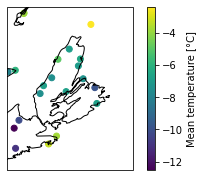

In [9]:
from matplotlib import pyplot as plt
import cartopy
from cartopy import crs as ccrs

# Create map projection
proj = ccrs.PlateCarree()

# If using another projection, remember you'll need to reproject the snapshot's coordinates.
# snapshot.to_crs(proj, inplace=True)

# Create figure and axes
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(projection=proj)

# Set the map extent to the bounding box and draw the coastlines
ax.set_extent([bbox[0], bbox[2], bbox[1], bbox[3]])
ax.coastlines()

# Plot markers color-coded according to the temperature recorded.
ax = snapshot.plot(column="MEAN_TEMPERATURE", ax=ax, cmap=plt.cm.viridis, legend=True)

# Add a label to the colorbar
cax = ax.figure.axes[-1]
cax.set_ylabel("Mean temperature [°C]")

Another useful filter is on dates and times. Let's say we only want data in a given period, we simply create a request with the `datetime` argument and a `/` separating the start and end dates. You may leave the start or end date open-ended using `..` instead of a date time string.

In [10]:
url = str(coll.with_query({"CLIMATE_IDENTIFIER": station_id, "datetime": "1990-01-01 00:00:00/1991-01-01 00:00:00"}))
print(url)
gdf = gpd.read_file(url)

https://api.weather.gc.ca//collections/climate-daily/items?CLIMATE_IDENTIFIER=8201410&datetime=1990-01-01+00%3A00%3A00%2F1991-01-01+00%3A00%3A00


In [11]:
# Convert the datetime string to a datetime object
gdf["LOCAL_DATE"] = pd.to_datetime(gdf["LOCAL_DATE"])

# Create a time series out of the column for mean temperature
ts = gdf.set_index("LOCAL_DATE")["MEAN_TEMPERATURE"]

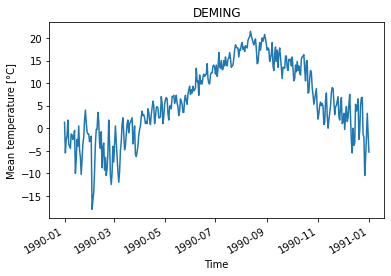

In [12]:
# Plot the time series
ax = ts.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Mean temperature [°C]")
ax.set_title(gdf.iloc[0]["STATION_NAME"])
plt.show()